# Flanker

This Python notebook serves as a template for your group project for the course "Modeling in Cognitive Science".

This is the practical part of the group project where you get to implement the computational modeling workflow. In this part, you are expected to:


*   Implement at least two computational models relevant for your hypothesis. *(3 points)*
*   Simulate behavior from the two models. *(3 points)*
*   Implement a procedure for fitting the models to data. *(4 points)*
*   Implement a procedure for parameter recovery. *(5 points)*
*   (Implement a procedure for model recovery.) *(optional; 2 bonus points)*
*   Implement a model comparison. *(5 points)*.

You can gain a total of 20 points for the practical part of the group project.

**Note:** *Some of the exercises below (e.g. Model Simulation) rely on code from previous exercises (e.g., Model Implementation). In such cases, you are encouraged to rely on functions implemented for previous exercises. That is, you don't have to produce redundant code.*



## Model Implementation *(3 points)*

For this exercise you should:

*   Implement and simulate data from two* models that are suitable to test your hypothesis. *(3 points)*

<font size=2>*You may implement more than two models if you wish. However, two models are sufficient for this group project.</font>

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


In [ ]:
#!pip install git+https://github.com/lnccbrown/HSSM.git

In [ ]:
# necessary imports
from matplotlib import pyplot as plt
import numpy as np
import hssm
import hssm.plotting
hssm.set_floatX("float32")
import pandas as pd
import arviz as az
from scipy.stats import norm
import random

import warnings
warnings.filterwarnings("ignore")

The following code defines two classes, Spotlight_DDM and Spotlight_DDM_with_variable_z, representing variants of the drift diffusion model (DDM), and a plotting function to visualize the simulation results.

**Spotlight_DDM:**

*   This class represents a basic implementation of the drift diffusion model.
*   It simulates the accumulation of evidence over time without any adjustment to the starting point (z) during the simulation.
*   The starting point remains constant throughout the simulation, as specified during initialization.
*   The decision-making process relies solely on the fixed starting point, drift rate, and noise.

**Spotlight_DDM_with_variable_z:**

*   This class extends the basic drift diffusion model by introducing a mechanism to adjust the starting point (z) during the simulation.
*   It allows the starting point to dynamically change based on the decision outcomes during the simulation.
*   When a decision is made (reaching one of the decision thresholds), the starting point is adjusted in the direction of the decision to bias future decisions.
*   This adjustment mechanism can be useful for modeling cognitive processes where decision biases or adjustments occur over time, such as learning or adaptation to changing environments.


The main difference between the two models lies in the treatment of the starting point (z): the basic model keeps it fixed, while the extended model allows it to be adjusted dynamically during simulation based on decision outcomes.

*The targeted hypothesis is that after the multiple trials where the flanker pointed in a certain direction, the participant is biased towards or against this flanker direction and the the offset (the starting point z) shifts towards one of the decision boundaries.*

In [4]:
# Class for simulating the DDM with fixed starting point
class Spotlight_DDM():
    def __init__(self, name):
        """
        Initialize the Spotlight_DDM object.

        Args:
        - name (str): A name to distinguish different instances of the model.
        """
        self.name = name # to distinguish models properly


    def run(self, v,
                threshold,
                starting_point,
                noise_std,
                non_decision_time,
                dt,
                max_time):
        """
        Simulates the Drift Diffusion Model for one run with fixed time increments to match evidence points.

        Arguments:
        - p_total: perceptual input for target and distractor flankers of shape [target, distractors] (values can be -1 (left) or 1(right))
        - sd_a: standard deviation of attention allocation distribution (spotlight width)
        - r: temporal decay of the standard deviation of attention (spotlight narrowing term)
        - threshold: evidence needed to reach a decision
        - starting_point: initial condition of the evidence
        - noise_std: standard deviation of the noise term
        - non_decision_time: time not included in the evidence accumulation process
        - dt: time increment
        - max_time: maximum simulation time

        Returns:
        - decision_time: the time taken to reach a decision
        - evidence_over_time: the evidence accumulated over time
        - decision: 1 if the decision boundary reached is the upper threshold, -1 if lower
        """
        # Initialize evidence accumulation process
        time = non_decision_time
        evidence = starting_point
        evidence_over_time = [evidence]

        # Run the simulation until a decision boundary is reached or max time is exceeded
        while time < max_time:
            # Increment the evidence by the drift and some noise
            evidence += v * dt + np.sqrt(dt) * np.random.normal(0, noise_std)
            evidence_over_time.append(evidence)
            time += dt  # Increment the time

            # Check if the evidence has reached either threshold
            if evidence >= threshold:
                return time, evidence_over_time, 1  # Decision made for the upper threshold (right)
            elif evidence <= 0:
                return time, evidence_over_time, -1  # Decision made for the lower threshold (left)

        # If no decision has been made by max_time, return the current state
        return time, evidence_over_time, 0


# Class for simulating the Drift Diffusion Model (DDM) with variable starting point (z)
class Spotlight_DDM_with_variable_z():
    def __init__(self, name, starting_point: float):
        """
        Initialize the Spotlight_DDM_with_variable_z object.

        Args:
        - name (str): A name to distinguish different instances of the model.
        - starting_point (float): Initial starting point for evidence accumulation.
        """
        self.name = name  # to distinguish models properly
        self.starting_point = starting_point
        self.z = starting_point

    def run(self, v, threshold, noise_std, non_decision_time, dt, max_time, increment_step: float = 0):
        """
        Simulates the Drift Diffusion Model for one run with fixed time increments to match evidence points.

        Arguments:
        - v: perceptual input for target flanker (values can be -1 (left) or 1(right))
        - sd_a: standard deviation of attention allocation distribution (spotlight width)
        - r: temporal decay of the standard deviation of attention (spotlight narrowing term)
        - threshold: evidence needed to reach a decision
        - noise_std: standard deviation of the noise term
        - non_decision_time: time not included in the evidence accumulation process
        - dt: time increment
        - max_time: maximum simulation time
        - increment_step: increment to adjust

        Returns:
        - decision_time: the time taken to reach a decision
        - evidence_over_time: the evidence accumulated over time
        - decision: 1 if the decision boundary reached is the upper threshold, -1 if lower
        """
        # Initialize evidence accumulation process
        time = non_decision_time
        evidence = self.z
        evidence_over_time = [evidence]

        # Run the simulation until a decision boundary is reached or max time is exceeded
        while time < max_time:
            # Increment the evidence by the drift and some noise
            evidence += v * dt + np.sqrt(dt) * np.random.normal(0, noise_std)
            evidence_over_time.append(evidence)
            time += dt  # Increment the time

            # Check if the evidence has reached either threshold
            if evidence >= threshold:
                # Decision made for the upper threshold
                self.adjust_starting_point(1, increment_step)
                return time, evidence_over_time, 1

            elif evidence <= 0:
                # Decision made for the lower threshold
                self.adjust_starting_point(-1, increment_step)
                return time, evidence_over_time, -1

        # If no decision has been made by max_time, return the current state
        return time, evidence_over_time, 0

    def adjust_starting_point(self, direction: int, increment: float):
        """
        Adjust the starting point (z) based on the direction of the decision and the specified increment.

        Args:
        - direction (int): Direction of the decision (-1 for left, 1 for right).
        - increment (float): Increment value to adjust the starting point.
        """
        if (self.z >= self.starting_point and direction == 1) or (self.z <= self.starting_point and direction == -1):
            self.z += increment * direction
            # print(f"Adjusted to {self.z}")
        else:
            self.z = self.starting_point
            # print("Reset to default.")



def plotting(decision_time, evidence_over_time, decision):
    """
    Plot the evidence accumulation process.

    Args:
    - decision_time (float): Time taken to reach a decision.
    - evidence_over_time (list): Evidence accumulated over time.
    - decision (int): Decision outcome (1 for right, -1 for left, 0 for no decision).
    """
    plt.plot(np.linspace(t0+0, t0+decision_time, len(evidence_over_time)), evidence_over_time)
    plt.axhline(y=a, color='green', linestyle='--')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Evidence')
    plt.title(f'Drift Diffusion Model (Decision: {"Right" if decision == 1 else "Left" if decision == 0 else "None"})')
    plt.show()
    return



## Model Simulation *(3 points)*

For this exercise you should:

*   Simulate data from both models for a single set of parameters. The simulation should mimic the experiment you are trying to model. *(2 points)*

*   Plot the simulated behavior of both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


The following code snippet sets parameters for simulating the **Spotlight_DDM** and then visualizes the evidence accumulation process.

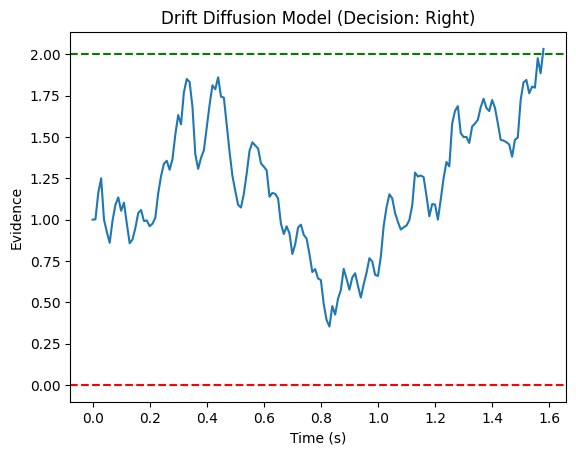

In [5]:
ddm = Spotlight_DDM("my_ddm")
p_total = 1 # incongruent trial with target pointing to the right and distractors pointing left
r = 0.2           # attention narrowing parameter
sd_a = 1          # initial attention standard deviation
a = 2             # threshold
z = a/2           # starting point (between 0 and threshold a)
sigma = 1         # standard deviation of noise
t0 = 0            # non-decision time
dt = 0.01         # integration constant
max_time = 1000   # maximum number of simulated seconds

# Run the DDM simulation
decision_time, evidence_over_time, decision = ddm.run(v = p_total,
                                                  threshold = a,
                                                  starting_point = z,
                                                  noise_std = sigma,
                                                  non_decision_time = t0,
                                                  dt = dt,
                                                  max_time = max_time)

# Plot the evidence accumulation process
plotting(decision_time, evidence_over_time, decision)

The following code snippet sets parameters for simulating the **Spotlight_DDM_with_variable_z** and then visualizes the evidence accumulation process.

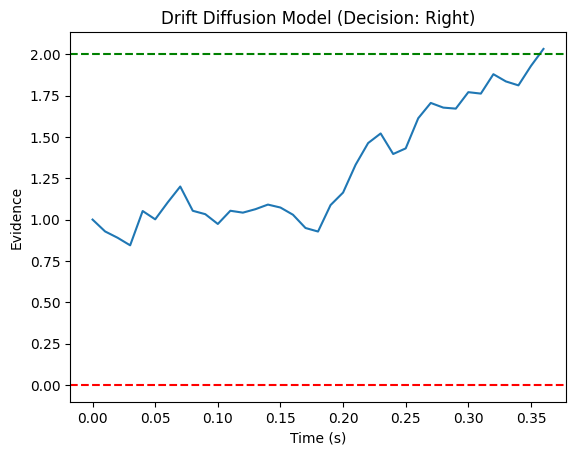

In [6]:
p_total = 1 # incongruent trial with target pointing to the right and distractors pointing left
r = 0.2           # attention narrowing parameter
sd_a = 1          # initial attention standard deviation
a = 2             # threshold
z = a/2           # starting point (between 0 and threshold a)
increment = 0.1   # directional increment for adjusting the z-param
sigma = 1         # standard deviation of noise
t0 = 0            # non-decision time
dt = 0.01         # integration constant
max_time = 1000   # maximum number of simulated seconds

ddm = Spotlight_DDM_with_variable_z("my_variable_ddm", starting_point = z)

# Run the DDM simulation
decision_time, evidence_over_time, decision = ddm.run(v = p_total,
                                                  threshold = a,
                                                  increment_step = increment,
                                                  noise_std = sigma,
                                                  non_decision_time = t0,
                                                  dt = dt,
                                                  max_time = max_time)

# Plot the evidence accumulation process
plotting(decision_time, evidence_over_time, decision)

## Parameter Fitting *(4 points)*

For this exercise you should:

*   Set up a suitable parameter search space *(1 point)*

*   Implement a procedure to evaluate the fit of a model based on data *(2 points)*

*   Implement a procedure for searching the parameter space. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.



This code snippet conducts Bayesian inference through Markov Chain Monte Carlo (MCMC) sampling for two drift diffusion models. The process involves executing Bayesian inference for both models using the NUTS (No-U-Turn Sampler) algorithm implemented in NumPyro. Configurations for the sampling process include parameters like the number of chains, draws, tune steps, and the type of data used for model comparison.

In [15]:
# using MCMC sampling
# 1) load the data
data = pd.read_csv("../data/3029.csv", delimiter = ";")
data.head()

# 2) prepare the models

varying_starting_point_model = hssm.HSSM(
    data = data,
    include=[
        {
            "name": "z",
            "formula": "z ~ 1 + previous_response",
        }
    ],
)

basic_ddm_model = hssm.HSSM(
    data = data,
)


# 3) fit both models using mcmc sampling
varying_starting_point_model_inference = varying_starting_point_model.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    chains=4,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

basic_ddm_model_inference = basic_ddm_model.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    chains=4,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

sample: 100%|██████████| 2000/2000 [00:13<00:00, 144.69it/s, 7 steps of size 4.63e-01. acc. prob=0.92]


In this snippet the traces from each model's Bayesian inference are passed as input to the az.compare function.


In [16]:
# Compare the models based on their posterior probabilities
model_comparison = az.compare(
    {
        "varying starting point": varying_starting_point_model.traces,
        "basic": basic_ddm_model.traces,
    }
)

The output of az.compare provides a comparison between the models, typically in terms of statistical metrics such as WAIC (Widely Applicable Information Criterion) or LOO (Leave-One-Out) cross-validation.

In [17]:
model_comparison

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
basic,0,-1364.606535,911.215780,0.000000,1.0,0.017134,0.000000,False,log
varying starting point,1,-2224.626123,827.784218,860.019588,0.0,127.213816,127.209467,True,log


The plot_trace() function is called on the **varying_starting_point_model** object to generate trace plots that visualize the sampled values of parameters over iterations (chains) of the MCMC sampling process.

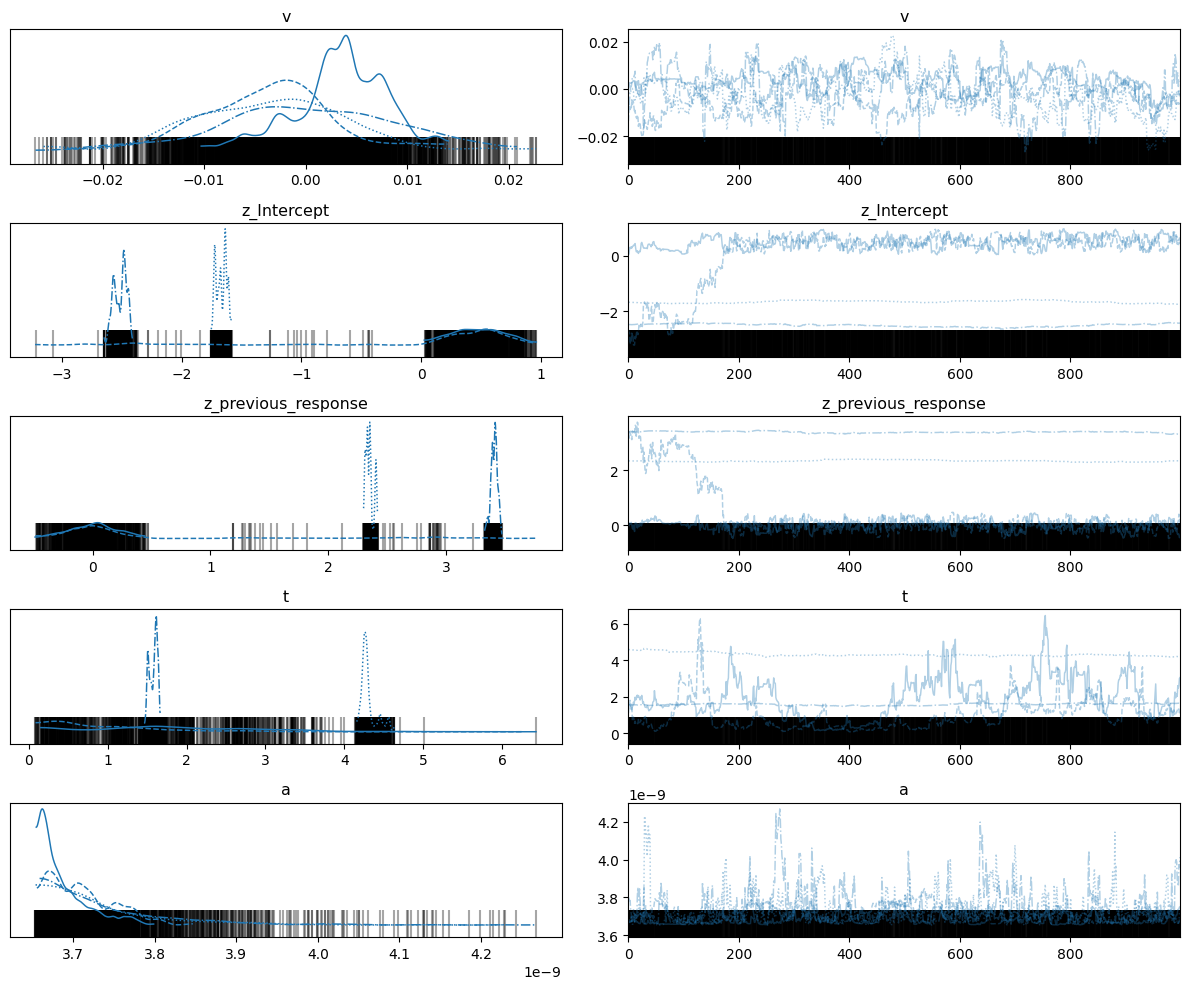

In [18]:
varying_starting_point_model.plot_trace()

The plot_trace() function is called on the **basic_ddm_model** object to generate trace plots that visualize the sampled values of parameters over iterations (chains) of the MCMC sampling process.

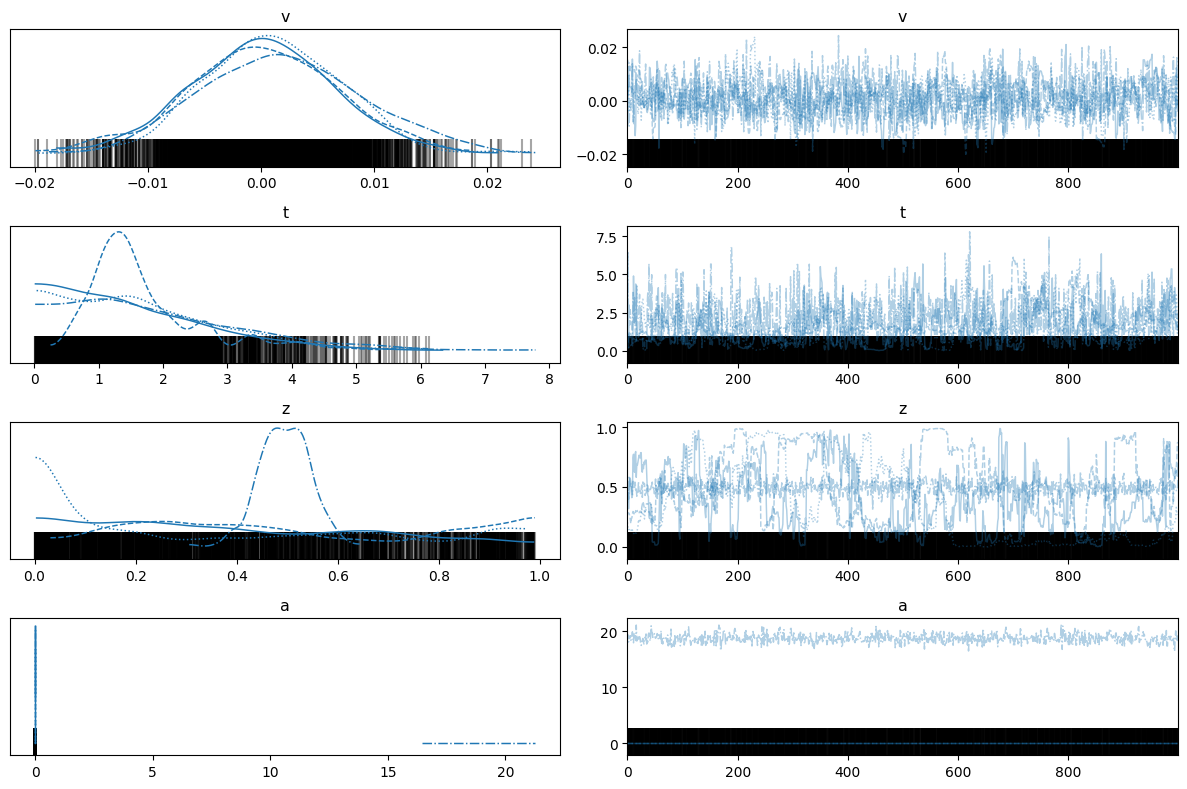

In [19]:
basic_ddm_model.plot_trace()

In the following code we do the same as before for 3029.csv - so creating the models, conducting Bayesian inference using MCMC sampling, comparing the models using ArviZ and creating trace plots for both models - just with the official Stanford data and some data manipulation to prepare it for modeling.

sample: 100%|██████████| 2000/2000 [00:06<00:00, 296.31it/s, 1 steps of size 1.18e-38. acc. prob=0.00]


                        rank      elpd_loo       p_loo   elpd_diff  \
basic                      0 -82851.735504   99.955177    0.000000   
varying starting point     1 -83170.945862  106.556465  319.210358   

                              weight        se      dse  warning scale  
basic                   1.000000e+00  5.945544  0.00000     True   log  
varying starting point  2.980949e-13  0.613819  5.93711     True   log  


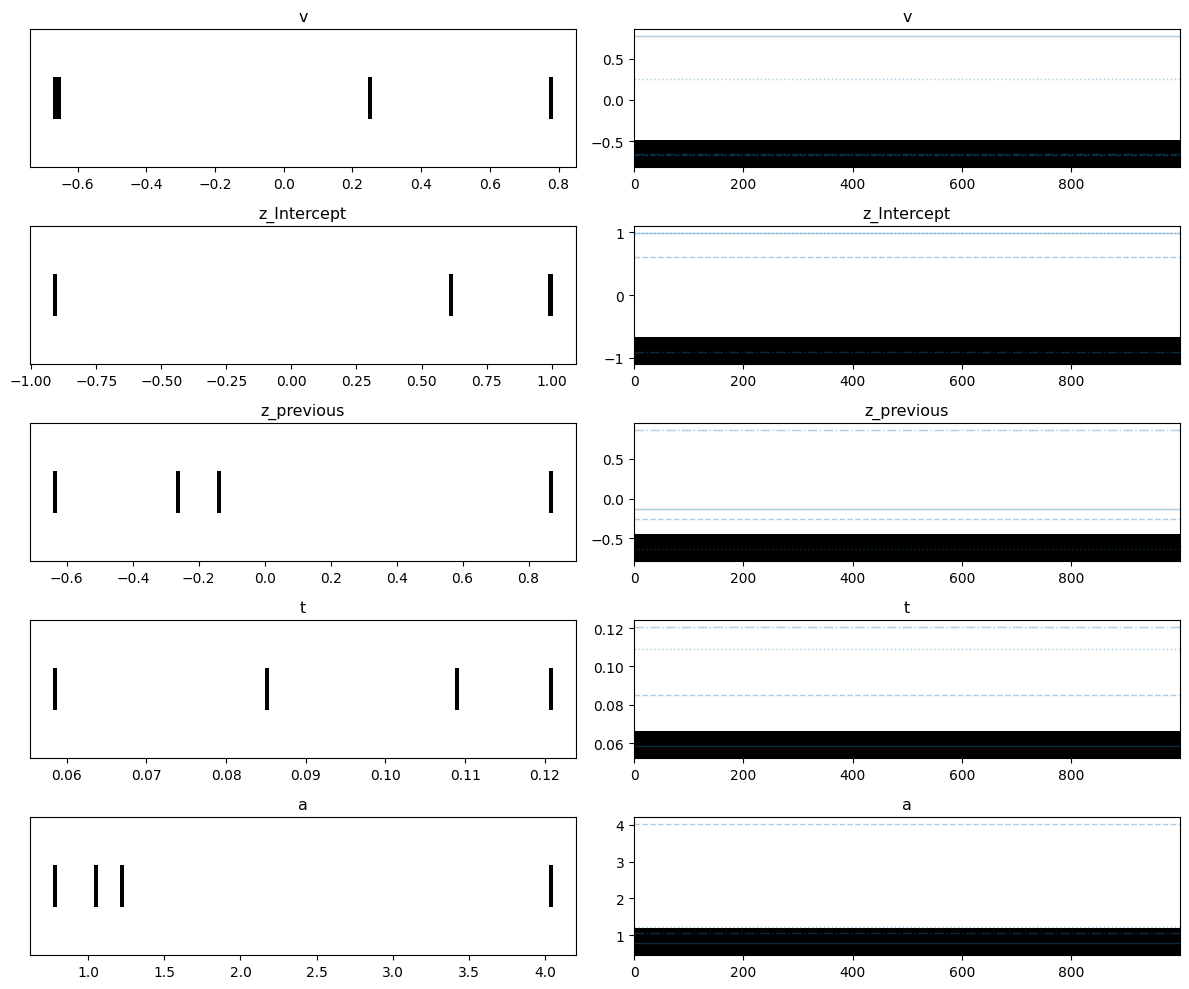

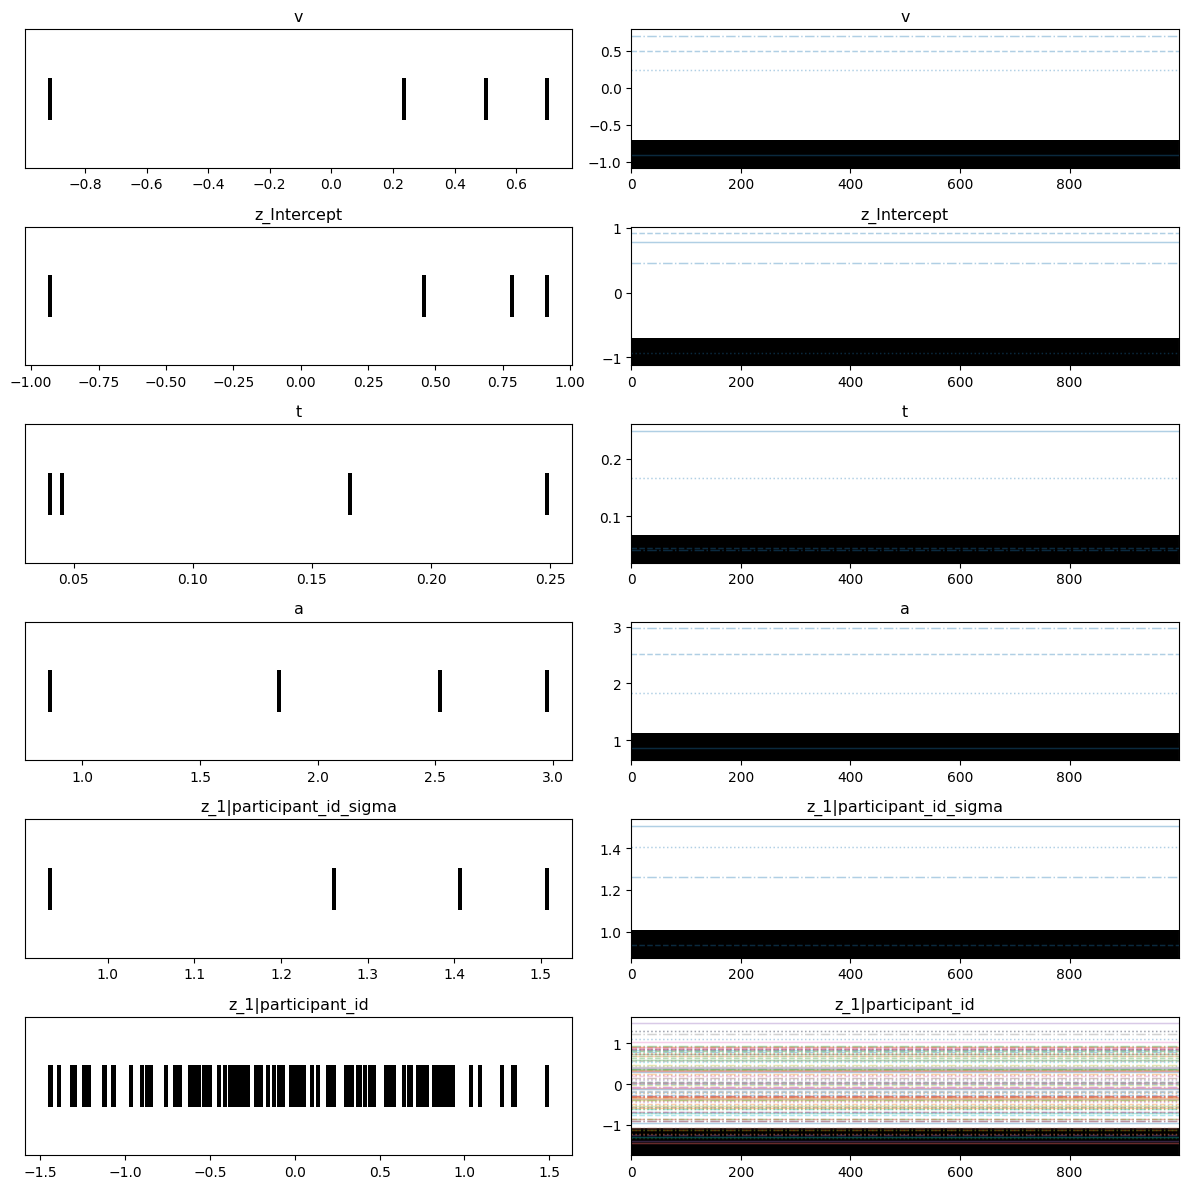

In [20]:
official_data = pd.read_csv("../data/data.csv", delimiter = ",")

# make StimVar the response column and switch values everywhere, where there is a 0 in Response
# Adjust column names and data types, drop unnecessary columns
falsies = np.where(official_data["Response"] == 0)[0]

for index in range(len(falsies)):
    official_data.at[falsies[index], "StimVar"] = 1 if official_data.at[falsies[index], "StimVar"] == 2 else 2

# Create a new column 'previous' with the shifted values of 'StimVar'
official_data['previous'] = official_data.loc[:, 'StimVar']
official_data['previous'] = official_data['StimVar'].shift(1)

# Drop unnecessary columns and rename columns for clarity
official_data = official_data.drop(['Response', 'Condition', 'Onset', 'Block'], axis = 1)
official_data = official_data.rename(columns={"SubjectID": "participant_id", "StimVar": "response", "RT": "rt"})

# Encode 'response' column values as -1 and 1
official_data["response"] = np.where(official_data["response"] == 2, 1, -1)
official_data.at[0, 'previous'] = 0
official_data['previous'] = official_data['previous'].astype('int')

# Create drift diffusion models with specified formulas
varying_starting_point_model_on_official_data = hssm.HSSM(
    data = official_data,
    include=[
        {
            "name": "z",
            "formula": "z ~ 1 + previous",
        }
    ],
)

basic_model_on_official_data = hssm.HSSM(
    data = official_data,
    include=[
        {
            "name": "z",
            "formula": "z ~ (1|participant_id)",
        }
    ],
)

# 3) fit both models using mcmc sampling
varying_starting_point_model_on_official_data_inference = varying_starting_point_model_on_official_data.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    chains=4,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

basic_model_on_official_data_inference = basic_model_on_official_data.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    chains=4,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

# Compare models using ArviZ
model_comparison = az.compare(
    {
        "varying starting point": varying_starting_point_model_on_official_data.traces,
        "basic": basic_model_on_official_data.traces,
    }
)
print(model_comparison)

# Generate trace plots for both models
varying_starting_point_model_on_official_data.plot_trace()
basic_model_on_official_data.plot_trace()

In the following code the data for the drift diffusion model is simulated using the simulate_data function from the hssm module, with specified parameters and a sample size of 500.

In [21]:
# Define parameters for the DDM simulation
v = 0.5             # drift rate
a = 2.0             # threshold
z = 1.0             # starting point (between 0 and threshold a)
t0 = 0.2            # non-decision time

true_values = [v, a, z, t0]

# Simulate data for the DDM using specified parameters
hssm_dataset = hssm.simulate_data(
    model="ddm",
    theta=true_values,
    size=500,
)

hssm_dataset

,rt,response
0,0.201343,1.0
1,0.200775,1.0
2,0.200783,1.0
3,0.201646,1.0
4,0.200773,1.0
...,...,...
495,0.204288,1.0
496,0.205739,1.0
497,0.222026,1.0
498,0.200923,1.0


## Parameter Recovery *(5 points)*

For this exercise you should:

*   Set up a suitable space of parameters relevant for parameter recovery *(1 point)*

*   Use the functions above to generate behavior from a models, for a given set of (randomly sampled) parameters, and then fit the model to its generated data. Make sure to evaluate the parameter fit in a quantiative manner. *(3 points)*

*   Plot the parameter recovery results for both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





This code snippet generates summary plots and computes Pearson correlation coefficients for the recovery of parameters in a drift diffusion model.

The function **parameter_recovery_plots** takes true and recovered values for drift diffusion model parameters as input.
It generates four scatter plots, each comparing true values with recovered values for one of the parameters (t, v, z, a).
Pearson correlation coefficients are computed and printed for each parameter to assess the recovery performance.

In [24]:
# summary plots

def parameter_recovery_plots(true_ts, recovered_ts, true_vs, recovered_vs, true_zs, recovered_zs, true_as, recovered_as):
    """
    Generates parameter recovery plots comparing true and recovered parameter values.

    Args:
        true_ts (array-like): True non-decision times.
        recovered_ts (array-like): Recovered non-decision times.
        true_vs (array-like): True drift rates.
        recovered_vs (array-like): Recovered drift rates.
        true_zs (array-like): True starting points.
        recovered_zs (array-like): Recovered starting points.
        true_as (array-like): True thresholds.
        recovered_as (array-like): Recovered thresholds.

    Returns:
        None, but prints the Pearson correlation coefficient for each parameter (t,v,z,a)
    """
    # Create subplots with 1 row and 2 columns
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4))  # Adjust the figsize as needed

    # Create the first scatter plot on the left
    ax1.scatter(true_ts, recovered_ts, marker='o', color='red')
    ax1.set_xlabel('True t')
    ax1.set_ylabel('Fitted t')
    ax1.set_title('Recovery of t')

    # Create the second scatter plot on the right
    ax2.scatter(true_vs, recovered_vs, marker='o', color='red')
    ax2.set_xlabel('True v')
    ax2.set_ylabel('Fitted v')
    ax2.set_title('Recovery of v')

    # Create the third scatter plot on the left
    ax3.scatter(true_zs, recovered_zs, marker='o', color='red')
    ax3.set_xlabel('True z')
    ax3.set_ylabel('Fitted z')
    ax3.set_title('Recovery of z')

    # Create the fourth scatter plot on the right
    ax4.scatter(true_as, recovered_as, marker='o', color='red')
    ax4.set_xlabel('True a')
    ax4.set_ylabel('Fitted a')
    ax4.set_title('Recovery of a')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Compute the Pearson correlation coefficient for t
    correlation_matrix = np.corrcoef(true_ts, recovered_ts)
    # The correlation coefficient is at (0, 1) in the correlation matrix
    correlation = correlation_matrix[0, 1]
    print(f"Pearson correlation coefficient for t: {correlation}")

    # Compute the Pearson correlation coefficient for v
    correlation_matrix = np.corrcoef(true_vs, recovered_vs)
    # The correlation coefficient is at (0, 1) in the correlation matrix
    correlation = correlation_matrix[0, 1]
    print(f"Pearson correlation coefficient for v: {correlation}")

    # Compute the Pearson correlation coefficient for z
    correlation_matrix = np.corrcoef(true_zs, recovered_zs)
    # The correlation coefficient is at (0, 1) in the correlation matrix
    correlation = correlation_matrix[0, 1]
    print(f"Pearson correlation coefficient for z: {correlation}")

    # Compute the Pearson correlation coefficient for a
    correlation_matrix = np.corrcoef(true_as, recovered_as)
    # The correlation coefficient is at (0, 1) in the correlation matrix
    correlation = correlation_matrix[0, 1]
    print(f"Pearson correlation coefficient for a: {correlation}")

The next code snippet performs parameter recovery analysis.

The code initializes arrays to log true and recovered parameters.
For each sample, it randomly selects true parameters within defined ranges, simulates data using these parameters, and performs Bayesian inference to recover the parameters.
True and recovered parameters are logged into arrays.
Finally, the **parameter_recovery_plots** function is called.

In [ ]:
random.seed(1)

# non-decision time
min_T = 0.0
max_T = 1.0

# drift rate
min_v = -1.0
max_v = 1.0

# starting point
min_z = 0.0
max_z = 2.0

# boundary separation
min_a = 0.1
max_a = 3.0

num_samples = 20

# prepare the logging arrays:
true_ts = np.zeros(num_samples)
true_vs = np.zeros(num_samples)
true_zs = np.zeros(num_samples)
true_as = np.zeros(num_samples)

recovered_ts = np.zeros(num_samples)
recovered_vs = np.zeros(num_samples)
recovered_zs = np.zeros(num_samples)
recovered_as = np.zeros(num_samples)


for index in range(num_samples):

    # randomly sample some parameters
    true_t = random.uniform(min_T, max_T)
    true_v = random.uniform(min_v, max_v)
    true_a = random.uniform(min_a, max_a)
    true_z = random.uniform(min_z, true_a) # z should never exceed a

    # log all true values
    for value, log in [(true_t, true_ts), (true_v, true_vs), (true_z, true_zs), (true_a, true_as)]:
      log[index] = value
      print(str(value))

    # simulate
    true_values = [true_v, true_a, true_z, true_t]

    hssm_dataset = hssm.simulate_data(
        model="ddm",
        theta=true_values,
        size=500,
    )

    # Perform MCMC sampling to infer the model parameters using the simulated data
    simulation_model = hssm.HSSM(
        data=hssm_dataset,
        model="ddm",
    )

    simulation_model_inference = simulation_model.sample(
        sampler="nuts_numpyro", # the specific MCMC sampling strategy we are using
                        # the number of CPU cores used to run MCMC sampling
        chains=2,               # the number of independent "runs" we sample through the room of parameters
        draws=1000,             # the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
        tune=1000,              # the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
        idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
    )

    # Summarize the MCMC traces
    summary = az.summary(simulation_model.traces)

    # log the recovered params
    for idx, log in enumerate([recovered_vs, recovered_zs, recovered_ts, recovered_as]):
        log[index] = summary["mean"][idx]

# Plot parameter recovery plots
parameter_recovery_plots(true_ts, recovered_ts, true_vs, recovered_vs, true_zs, recovered_zs, true_as, recovered_as)

0.13436424411240122
0.6948674738744653
0.5904711216198447
2.3149463950321807


sample: 100%|██████████| 2000/2000 [00:40<00:00, 49.03it/s, 59 steps of size 7.77e-02. acc. prob=0.94]


0.49543508709194095
-0.10101787042252375
1.5692594548780723
1.9896196208960126


warmup:  20%|█▉        | 398/2000 [01:31<08:45,  3.05it/s, 1023 steps of size 3.13e-04. acc. prob=0.78]

This function **simulate_increment_model** simulates multiple runs of a **DDM** with incremental changes in starting point


In [ ]:
def simulate_increment_model(num_simulations, model, t, v, a, increment):
  """
      Arguments:
        - num_simulations: number of simulation runs
        - model: the drift diffusion model
        - t: non-decision time
        - v: drift rate
        - a: threshold
        - increment: increment step for starting point


        Returns:
        - pd.DataFrame(log): the decision time and response for each run logged in a list of dictionaries and converted into a DF
  """
    # Initialize an empty list to store simulation results
    log = []

    # Perform simulation for the specified number of runs
    for run in range(num_simulations):
        decision_time, evidence, decision = model.run(v = v,
                                                  threshold = a,
                                                  increment_step = increment,
                                                  noise_std = 1,
                                                  non_decision_time = t,
                                                  dt = 0.01,
                                                  max_time = 1000)
        # Append simulation results (decision time and response) to the log list
        log.append({"rt": decision_time, "response": decision})

    # Convert the list of dictionaries into a pandas DataFrame and return it
    return pd.DataFrame(log)


The next snippet, again, initializes random seed and iterates over a specified number of samples, randomly sampling true parameters within defined ranges.
For each sample, it logs the true parameter values and simulates data using a surrogate model with incremental changes in starting point.
The script performs MCMC sampling on the simulated data to recover parameters.
Recovered parameter values are logged and used to generate parameter recovery plots.

In [ ]:
random.seed(2)

# non-decision time
min_T = 0.0
max_T = 1.0

# drift rate
min_v = -1.0
max_v = 1.0

# starting point
min_z = 0.0
max_z = 2.0

# boundary separation
min_a = 0.1
max_a = 3.0

# increment step
min_in = 0.001
max_in = 0.2

num_samples = 10

# prepare the logging arrays:
true_ts = np.zeros(num_samples)
true_vs = np.zeros(num_samples)
true_zs = np.zeros(num_samples)
true_as = np.zeros(num_samples)
true_ins = np.zeros(num_samples)

recovered_ts = np.zeros(num_samples)
recovered_vs = np.zeros(num_samples)
recovered_zs = np.zeros(num_samples)
recovered_as = np.zeros(num_samples)




# Iterate over the number of samples
for index in range(num_samples):

    # randomly sample some parameters
    true_t = random.uniform(min_T, max_T)
    true_v = random.uniform(min_v, max_v)
    true_a = random.uniform(min_a, max_a)
    true_z = random.uniform(min_z, true_a) # z should never exceed a
    true_increment = random.uniform(min_in, max_in)

    # log all true values
    for value, log in [(true_t, true_ts), (true_v, true_vs), (true_z, true_zs), (true_a, true_as), (true_increment, true_ins)]:
      log[index] = value
      print(str(value))

    # Create a surrogate model
    surrogate_model = Spotlight_DDM_with_variable_z(name = "simulation_model", starting_point = true_z)

    # Simulate data with incremental changes in starting point
    surrogate_data = simulate_increment_model(500, surrogate_model, true_t, true_v, true_a, true_increment)

    # Define the simulation model
    simulation_model = hssm.HSSM(
        data=surrogate_data,
        model="ddm",
    )

    # Perform MCMC sampling
    simulation_model_inference = simulation_model.sample(
        sampler="nuts_numpyro", # the specific MCMC sampling strategy we are using
                        # the number of CPU cores used to run MCMC sampling
        chains=2,               # the number of independent "runs" we sample through the room of parameters
        draws=1000,             # the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
        tune=1000,              # the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
        idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
    )

    # Summarize the posterior distribution
    summary = az.summary(simulation_model.traces)

    # log the recovered params
    for idx, log in enumerate([recovered_vs, recovered_zs, recovered_ts, recovered_as]):
        log[index] = summary["mean"][idx]

# Generate parameter recovery plots
parameter_recovery_plots(true_ts, recovered_ts, true_vs, recovered_vs, true_zs, recovered_zs, true_as, recovered_as)

## *Optional*: Model Recovery *(2 bonus points)*

In this bonus exercise, you may examine model reovery. The bonus points count towards your total group project points. That is, you may accumlate up to 22 points in the practical part of the group project.

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [ ]:
# YOUR MODEL RECOVERY CODE GOES HERE

## Model Comparison *(5 points)*

For this exercise you should:

*   Load and (potentially) preprocess the experimental data. (1 point)

*   Fit the two models to the data.  *(1 point)*

*   Evaluate which model performs better, taking into account fit and model complexity. *(2 points)*

*   Plot the behavior of the winning model against the data. *(1 point)**

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





The code loads experimental data from a CSV file.
It fits the two DDMs, performs MCMC sampling (using the NUTS sampler) to infer parameters for both models and compares them based on the traces obtained from MCMC sampling.
Finally, trace plots are generated for visualizing parameter estimates and convergence for both models.

In [ ]:
# Loading the experimental data
data = pd.read_csv("../data/3029.csv", delimiter=";")

# Fit Standard model
basic_ddm_model = hssm.HSSM(
    data = data,
)

# Perform MCMC sampling to infer parameters for the standard DDM
basic_ddm_model_inference = basic_ddm_model.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    chains=4,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)



# Fit Model with varying z-value
varying_starting_point_model = hssm.HSSM(
    data = data,
    include=[
        {
            "name": "z",
            "formula": "z ~ 1 + previous_response",
        }
    ],
)

# Perform MCMC sampling to infer parameters for DDM with varying starting point
varying_starting_point_model_inference = varying_starting_point_model.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    chains=4,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

# Compare the two models based on their traces
model_comparison = az.compare(
    {
        "varying starting point": varying_starting_point_model.traces,
        "basic": basic_ddm_model.traces,
    }
)

print(model_comparison)

# Plot traces for the standard DDM and DDM with varying starting point
basic_ddm_model.plot_trace()
varying_starting_point_model.plot_trace()